In [698]:
# pip install threadpoolctl=3.5.0
import os
import pandas as pd
import numpy as np
import seaborn as sns

# plotting packages
# %matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clrs

# Kmeans and allgomerativ clustering algorithm from scikit-learn
os.environ["OMP_NUM_THREADS"] = '1'   # To avoid memory leak
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
import warnings
warnings.filterwarnings("ignore")

In [699]:
# load raw data
raw = pd.read_csv('countryriskdata.csv')
# check the raw data
raw

,Country,Abbrev,Corruption,Peace,Legal,GDP Growth
0,Albania,AL,39,1.867,3.822,3.403
1,Algeria,DZ,34,2.213,4.160,4.202
2,Argentina,AR,36,1.957,4.568,-2.298
3,Armenia,AM,33,2.218,4.126,0.208
4,Australia,AU,79,1.465,8.244,2.471
...,...,...,...,...,...,...
117,Venezuela,VE,17,2.651,3.000,-18.000
118,Vietnam,VI,33,1.906,4.930,6.211
119,Yemen,YE,14,3.399,2.728,-9.779
120,Zambia,ZM,38,1.783,4.917,2.967


In [700]:
raw.describe()

,Corruption,Peace,Legal,GDP Growth
count,122.000000,122.000000,122.000000,122.000000
mean,46.237705,2.003730,5.598861,2.372566
std,19.126397,0.447826,1.487328,3.241424
min,14.000000,1.192000,2.728000,-18.000000
25%,31.250000,1.684750,4.571750,1.432250
50%,40.000000,1.969000,5.274000,2.496000
75%,58.750000,2.280500,6.476750,4.080000
max,90.000000,3.399000,8.633000,7.958000


# Part 1 - How Closely the Features are Correlated with Scatter Plots

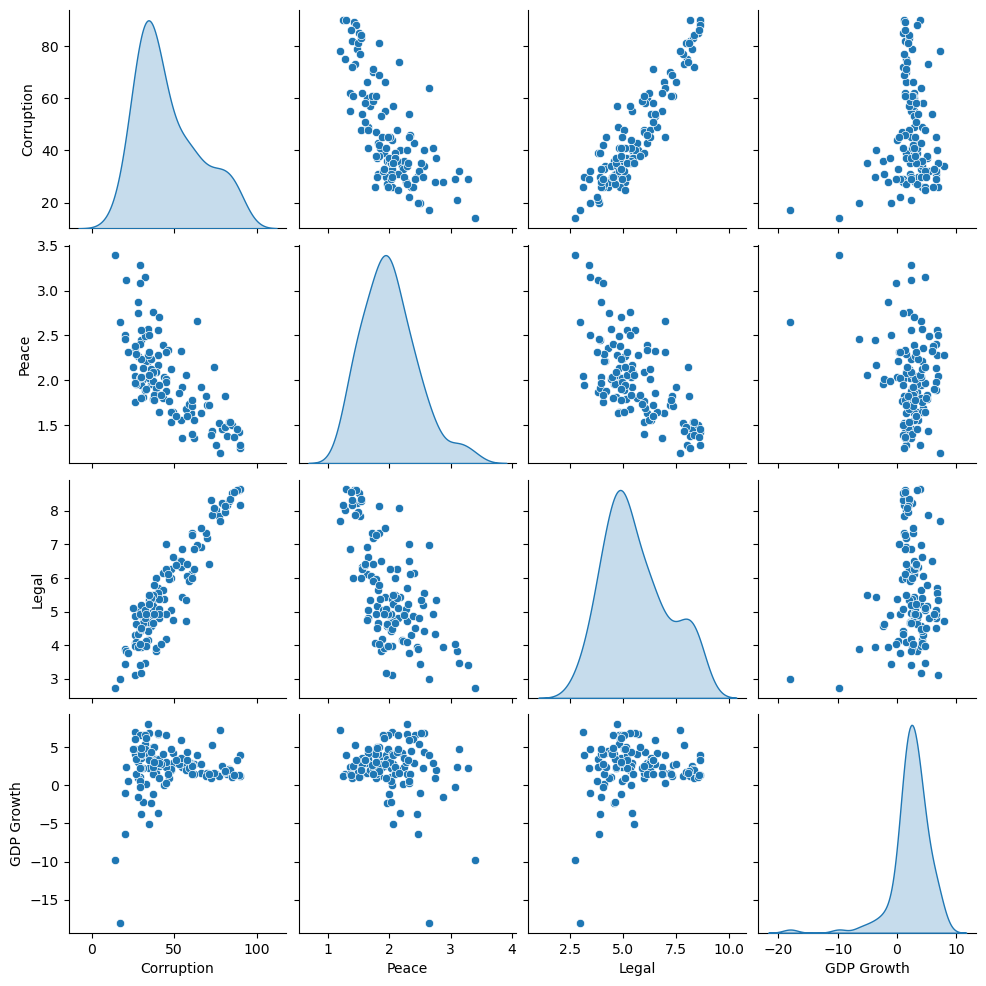

In [702]:
sns.pairplot(raw, vars=raw.columns[2:], diag_kind="kde")

# Part 2 - Normalizing Features to Give Them Equal Weight

In [704]:
scaler = StandardScaler()
data_to_normalize = raw[raw.columns[2:]] 
normalized_data = scaler.fit_transform(data_to_normalize)
raw[raw.columns[2:]] = normalized_data
raw

,Country,Abbrev,Corruption,Peace,Legal,GDP Growth
0,Albania,AL,-0.379975,-0.306578,-1.199593,0.319207
1,Algeria,DZ,-0.642472,0.469231,-0.971402,0.566720
2,Argentina,AR,-0.537473,-0.104778,-0.695954,-1.446841
3,Armenia,AM,-0.694971,0.480442,-0.994356,-0.670536
4,Australia,AU,1.720000,-1.207951,1.785784,0.030493
...,...,...,...,...,...,...
117,Venezuela,VE,-1.534961,1.451323,-1.754541,-6.310985
118,Vietnam,VI,-0.694971,-0.219131,-0.451561,1.189065
119,Yemen,YE,-1.692459,3.128505,-1.938173,-3.764295
120,Zambia,ZM,-0.432474,-0.494924,-0.460337,0.184143


# Part 3a - Determine Optimal Number of Clusters Using Elbow Method

In [706]:
def calculate_cluster_centers(data, n_clusters, cluster_labels): # Function to Calculate Cluster Centers for Agglomerative Clustering
    cluster_centers = []
    for cluster_id in range(n_clusters):
        cluster_points = data[cluster_labels == cluster_id]
        cluster_center = cluster_points.mean(axis=0)
        cluster_centers.append(cluster_center)
    cluster_centers = pd.DataFrame(cluster_centers, columns=data.columns[:4])
    return cluster_centers

In [707]:
def calculate_inertia(data, n_clusters, cluster_labels): # Function to Calculate Inertia for Agglomerative Clustering
    cluster_centers = calculate_cluster_centers(data, n_clusters, cluster_labels).values.tolist()
    inertia = 0.0
    for i, label in enumerate(cluster_labels):
        inertia += np.sum((data.iloc[i] - cluster_centers[label]) ** 2)
    return inertia

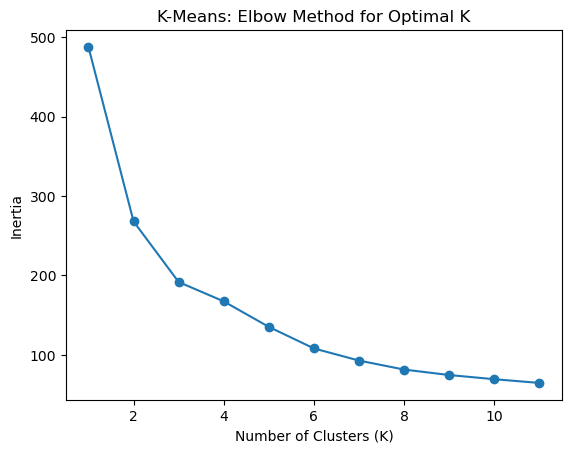

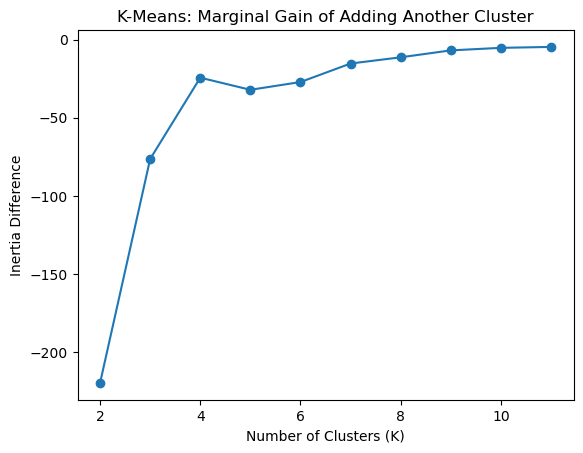

K-Means Optimal K: 2

Cluster 1:
Center: [-0.57858699  0.46009969 -0.54785866 -0.00482561]
Countries: ['Albania', 'Algeria', 'Argentina', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Benin', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burundi', 'Cameroon', 'Chad', 'China', 'Colombia', 'Croatia', 'Cyprus', 'Democratic Republic of Congo', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Ethiopia', 'Gabon', 'Georgia', 'Ghana', 'Greece', 'Guatemala', 'Honduras', 'India', 'Indonesia', 'Iran', 'Israel', 'Italy', 'Jamaica', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Lebanon', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mexico', 'Moldova', 'Montenegro', 'Morocco', 'Mozambique', 'Nepal', 'Nicaragua', 'Nigeria', 'Oman', 'Pakistan', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Romania', 'Russia', 'Rwanda', 'Saudi Arabia', 'Senegal', 'Serbia', 'Sierra Leone', 'South Africa', 'Sri Lanka', 'Tanzania', 'Thailand', 'The FYR of Macedonia', 'Trinidad and To

In [708]:
k_inertias = []
ksilhouette_scores = []
ac_inertias = []
ac_silhouette_scores = []
for i in range(1, 12):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(raw[raw.columns[2:]])
    ac = AgglomerativeClustering(n_clusters=i)
    ac_labels = ac.fit_predict(raw[raw.columns[2:]])
    if i > 1: # Compute silhouette scores
      ksilhouette_scores.append(silhouette_score(raw[raw.columns[2:]], kmeans.labels_)) 
      ac_silhouette_scores.append(silhouette_score(raw[raw.columns[2:]], ac_labels))
    k_inertias.append(kmeans.inertia_) # K-Means Inertia for Different Number of Clusters
    ac_inertias.append(calculate_inertia(raw[raw.columns[2:]], i, ac_labels)) # Agglomerative Clustering Inertia for Different Number of Clusters

plt.plot(range(1, 12), k_inertias, marker='o')
plt.title('K-Means: Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show() 

k_inertias_diff = np.diff(k_inertias) # To visualize the marginal gain of adding another cluster
plt.plot(range(2, 12), k_inertias_diff, marker='o')
plt.title('K-Means: Marginal Gain of Adding Another Cluster')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia Difference')
plt.show()

k_inertias_diff2 = np.diff(k_inertias_diff) # Computes optimal_k for k-means clustering
km_optimal_k = np.argmax(k_inertias_diff2) + 2
print("K-Means Optimal K:", km_optimal_k)

kmeans = KMeans(n_clusters=km_optimal_k, random_state=0)
kmeans.fit(raw[raw.columns[2:]])
raw['K-Means Elbow Method Cluster'] = kmeans.labels_

for i in range(km_optimal_k): # Reports the centres and countries in each cluster for k-means
    print(f"\nCluster {i+1}:")
    cluster_data = raw[raw['K-Means Elbow Method Cluster'] == i]
    print("Center:", kmeans.cluster_centers_[i])
    print("Countries:", cluster_data['Country'].tolist())

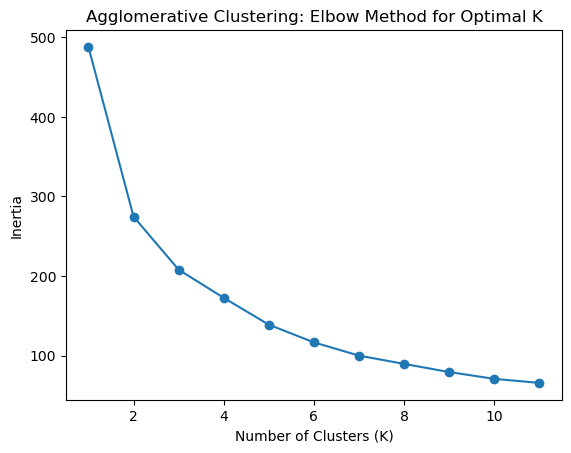

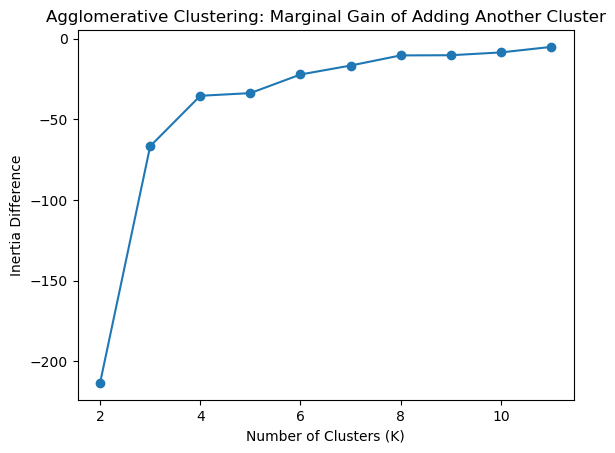

Agglomerative Clustering Optimal K: 2

Cluster 1:
Corruption   -0.578587
Peace         0.460100
Legal        -0.547859
GDP Growth   -0.004826
Name: 0, dtype: float64
Countries: ['Albania', 'Algeria', 'Argentina', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Benin', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burundi', 'Cameroon', 'Chad', 'China', 'Colombia', 'Croatia', 'Cyprus', 'Democratic Republic of Congo', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Ethiopia', 'Gabon', 'Georgia', 'Ghana', 'Greece', 'Guatemala', 'Honduras', 'India', 'Indonesia', 'Iran', 'Israel', 'Italy', 'Jamaica', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Lebanon', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mexico', 'Moldova', 'Montenegro', 'Morocco', 'Mozambique', 'Nepal', 'Nicaragua', 'Nigeria', 'Oman', 'Pakistan', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Romania', 'Russia', 'Rwanda', 'Saudi Arabia', 'Senegal', 'Serbia', 'Sierra Leone', 'South Africa', 'S

In [709]:
plt.plot(range(1, 12), ac_inertias, marker='o')
plt.title('Agglomerative Clustering: Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

ac_inertias_diff = np.diff(ac_inertias) # To visualize the marginal gain of adding another cluster for Agglomerative Clustering
plt.plot(range(2, 12), ac_inertias_diff, marker='o')
plt.title('Agglomerative Clustering: Marginal Gain of Adding Another Cluster')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia Difference')
plt.show()

ac_inertias_diff2 = np.diff(ac_inertias_diff) # Computes optimal_k for Agglomerative Clustering
ac_optimal_k = np.argmax(ac_inertias_diff2) + 2
print("Agglomerative Clustering Optimal K:",ac_optimal_k)

acmeans = AgglomerativeClustering(n_clusters=ac_optimal_k)
acmeans.fit(raw[raw.columns[2:]])
raw['Agglomerative Clustering Elbow Method Cluster'] = acmeans.labels_

for i in range(ac_optimal_k): # Reports the centres and countries in each cluster for Agglomerative Clustering
    print(f"\nCluster {i+1}:")
    cluster_data = raw[raw['Agglomerative Clustering Elbow Method Cluster'] == i]
    print(calculate_cluster_centers(raw[raw.columns[2:]], ac_optimal_k, acmeans.labels_).iloc[i])
    print("Countries:", cluster_data['Country'].tolist())

# Part 3b - Ranking Clusters According to Country Risk

In [711]:
# Lower values in Corruption and GDP Growth indicate higher risk, 
# while higher values in Peace and Legal indicate higher risk

k_cluster_risk_scores = [] # Risk Scores for K-Means Clusters
for i in range(km_optimal_k):
  k_cluster_data = raw[raw['K-Means Elbow Method Cluster'] == i]
  avg_corruption = k_cluster_data['Corruption'].mean()
  avg_gdp_growth = k_cluster_data['GDP Growth'].mean()
  avg_peace = k_cluster_data['Peace'].mean()
  avg_legal = k_cluster_data['Legal'].mean()
  # print(avg_corruption, avg_gdp_growth, avg_peace, avg_legal)

  # Combining the risk scores into a single risk score for the cluster
  k_cluster_risk_score =  avg_peace + avg_legal - avg_corruption - avg_gdp_growth
  k_cluster_risk_scores.append((i, k_cluster_risk_score))

# Sorting the K-Means clusters based on their risk scores in descending order (higher risk first)
sorted_km_clusters = sorted(k_cluster_risk_scores, key=lambda x: x[1], reverse=True)

print("K-Means Cluster Rank based on Country Risk (Higher score = Higher risk):")
for rank, (cluster_id, risk_score) in enumerate(sorted_km_clusters):
    print(f"Rank {rank + 1}: Cluster {cluster_id + 1} (Risk Score: {risk_score:.2f})")

K-Means Cluster Rank based on Country Risk (Higher score = Higher risk):
Rank 1: Cluster 1 (Risk Score: 0.50)
Rank 2: Cluster 2 (Risk Score: -1.05)


In [712]:
ac_cluster_risk_scores = [] # Risk Scores for Agglomerative Clusters
for i in range(ac_optimal_k):
  ac_cluster_data = raw[raw['Agglomerative Clustering Elbow Method Cluster'] == i]
  avg_corruption = ac_cluster_data['Corruption'].mean()
  avg_gdp_growth = ac_cluster_data['GDP Growth'].mean()
  avg_peace = ac_cluster_data['Peace'].mean()
  avg_legal = ac_cluster_data['Legal'].mean()
  # print(avg_corruption, avg_gdp_growth, avg_peace, avg_legal)

  # Combining the risk scores into a single risk score for the cluster
  ac_cluster_risk_score =  avg_peace + avg_legal - avg_corruption - avg_gdp_growth
  ac_cluster_risk_scores.append((i, ac_cluster_risk_score))

# Sorting the Agglomerative Clusters based on their risk scores in descending order (higher risk first)
sorted_ac_clusters = sorted(ac_cluster_risk_scores, key=lambda x: x[1], reverse=True)

print("Agglomerative Cluster Rank based on Country Risk (Higher score = Higher risk):")
for rank, (cluster_id, risk_score) in enumerate(sorted_ac_clusters):
    print(f"Rank {rank + 1}: Cluster {cluster_id + 1} (Risk Score: {risk_score:.2f})")

Agglomerative Cluster Rank based on Country Risk (Higher score = Higher risk):
Rank 1: Cluster 1 (Risk Score: 0.50)
Rank 2: Cluster 2 (Risk Score: -1.05)


# Part 4 - Compute Silhouette Scores & Determine Optimal Number of Clusters

Silhouette score for k=2: 0.42419957148827603
Silhouette score for k=3: 0.398215460412785
Silhouette score for k=4: 0.2820926118965521
Silhouette score for k=5: 0.2836665165179716
Silhouette score for k=6: 0.31174375319819825
Silhouette score for k=7: 0.32042476616883536
Silhouette score for k=8: 0.30877929938391135
Silhouette score for k=9: 0.29241356661073425
Silhouette score for k=10: 0.28675567121693785
Silhouette score for k=11: 0.2833569965434149


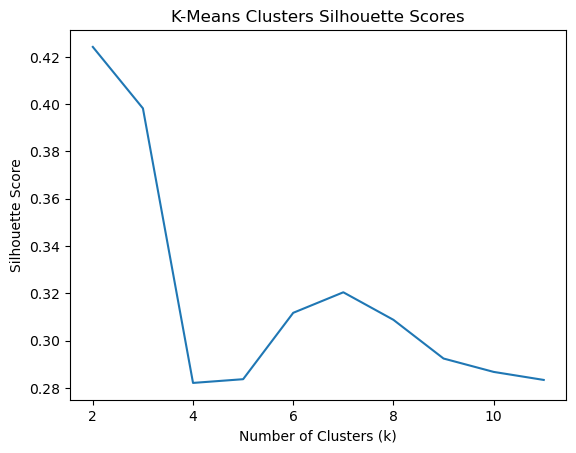

Optimal number of K-Means Clusters Based on Silhouette Analysis: 2


In [714]:
# For K-Means
for i, score in enumerate(ksilhouette_scores):
  print(f"Silhouette score for k={i + 2}: {score}")

# Plotting scores for better visualization
plt.plot(range(2, 12), ksilhouette_scores)
plt.title("K-Means Clusters Silhouette Scores")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

optimal_k_s = np.argmax(ksilhouette_scores) + 2
print(f"Optimal number of K-Means Clusters Based on Silhouette Analysis: {optimal_k_s}")

Silhouette score for k=2: 0.3986468126370577
Silhouette score for k=3: 0.3618381627237927
Silhouette score for k=4: 0.3483864079185631
Silhouette score for k=5: 0.3131769713309422
Silhouette score for k=6: 0.32694337084253083
Silhouette score for k=7: 0.30988339680684984
Silhouette score for k=8: 0.30119597289453187
Silhouette score for k=9: 0.292275321264679
Silhouette score for k=10: 0.2767028554570944
Silhouette score for k=11: 0.2818926550600389


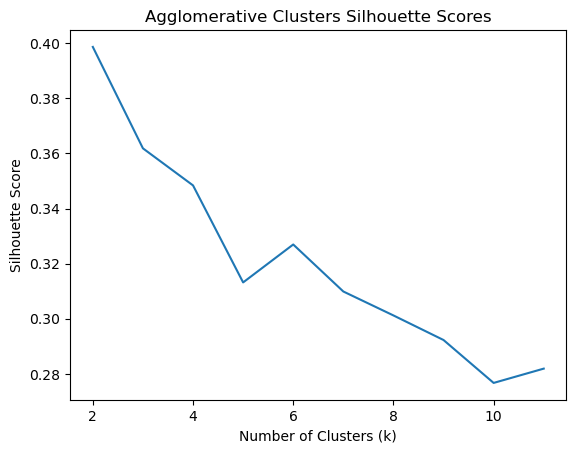

Optimal number of Agglomerative Clusters Based on Silhouette Analysis: 2


In [715]:
# For Agglomerative Cluster
for i, score in enumerate(ac_silhouette_scores):
  print(f"Silhouette score for k={i + 2}: {score}")

# Plot the scores for better visualization
plt.title("Agglomerative Clusters Silhouette Scores")
plt.plot(range(2, 12), ac_silhouette_scores)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

optimal_ac_s = np.argmax(ac_silhouette_scores) + 2
print(f"Optimal number of Agglomerative Clusters Based on Silhouette Analysis: {optimal_ac_s}")

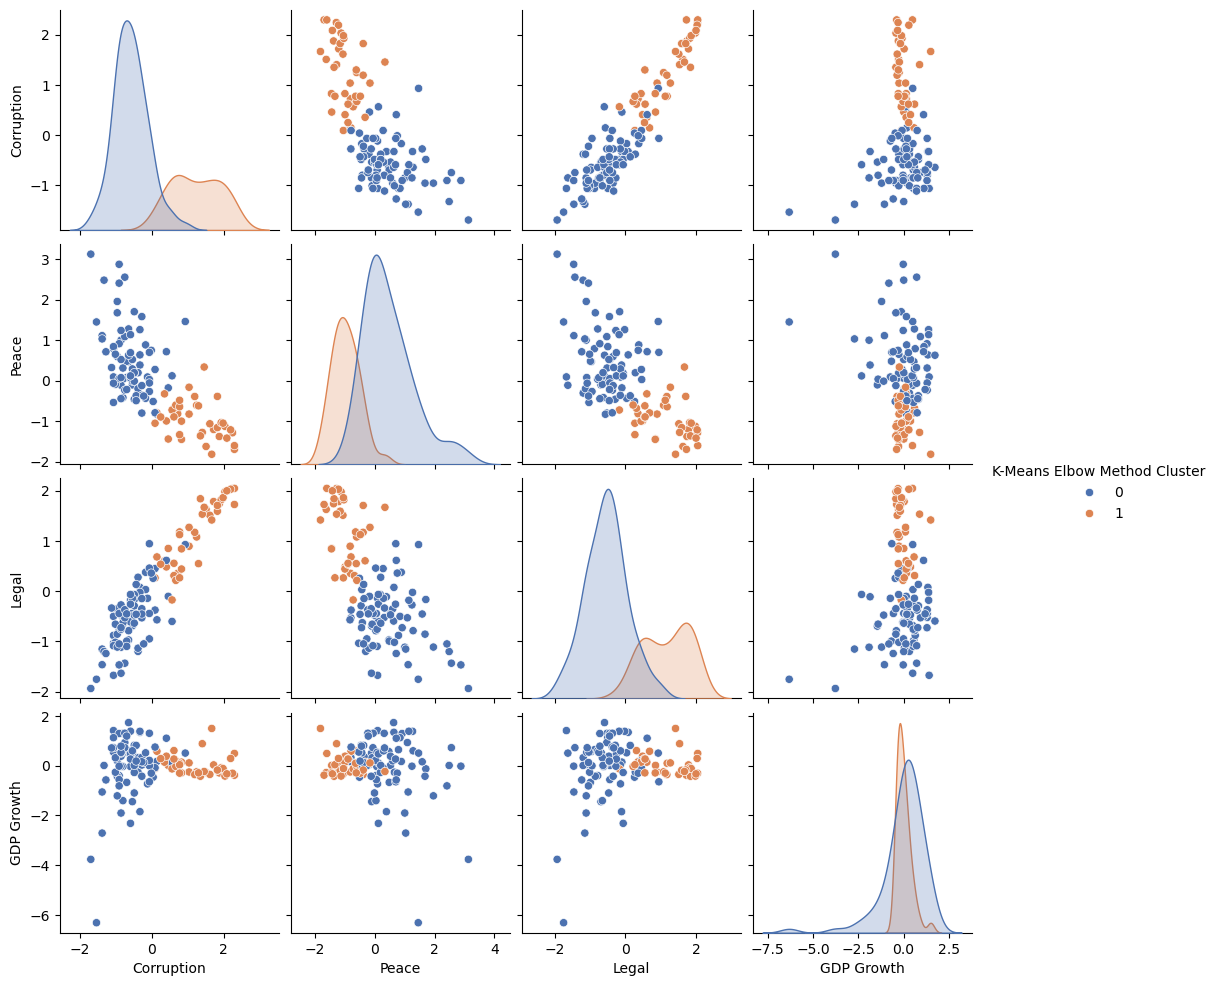

In [716]:
sns.pairplot(raw,vars=raw.columns[2:-2],hue="K-Means Elbow Method Cluster", palette='deep') # 

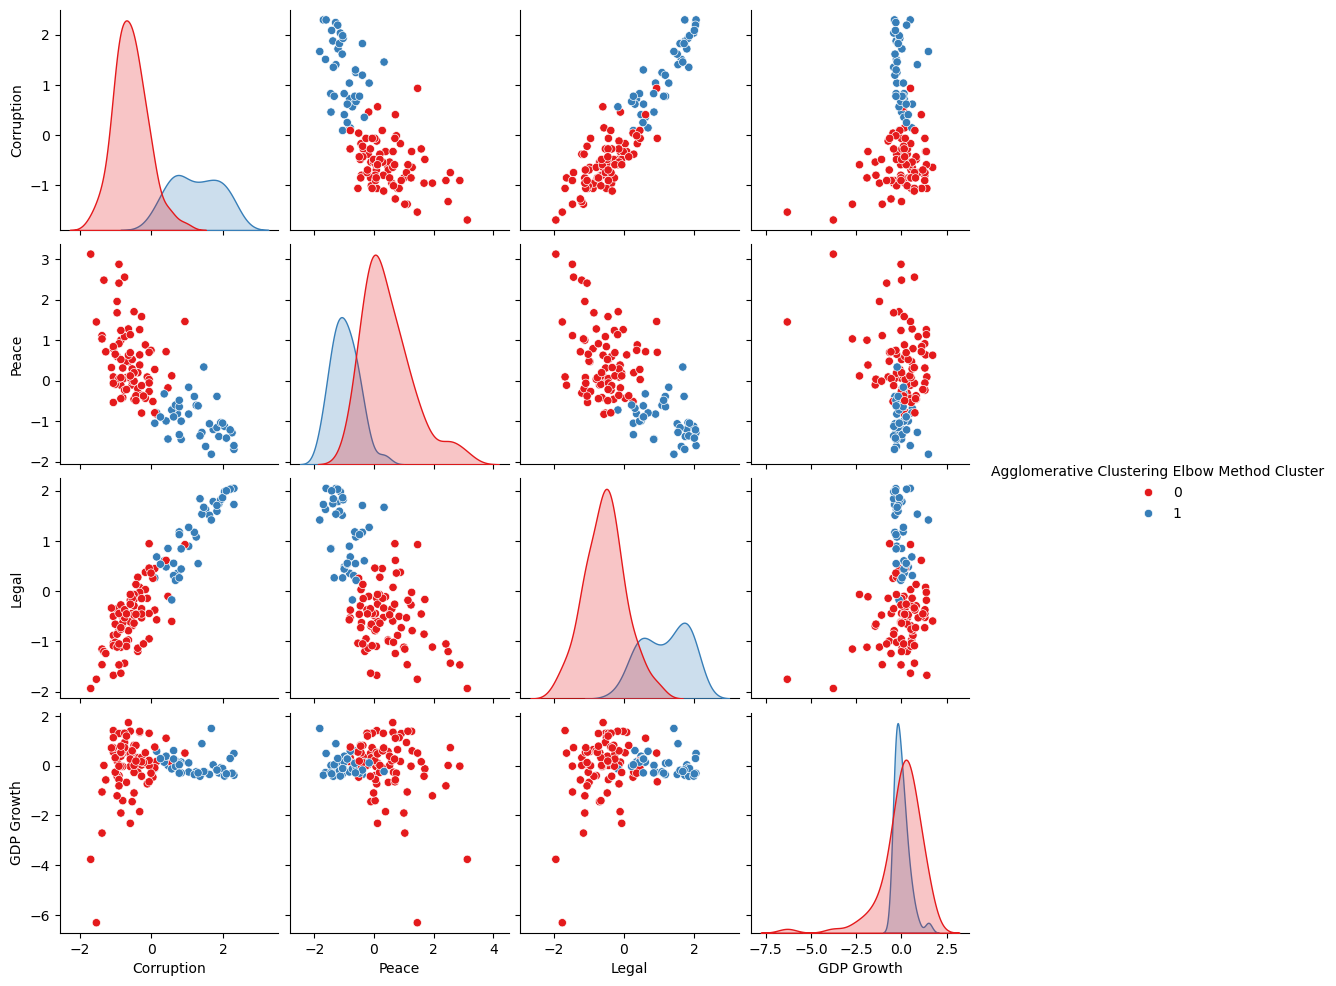

In [717]:
sns.pairplot(raw,vars=raw.columns[2:-2],hue='Agglomerative Clustering Elbow Method Cluster', palette='Set1')